In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import classification_report

In [4]:
train_path = "/content/drive/MyDrive/train.txt"
test_path = "/content/drive/MyDrive/test.txt"
val_path = "/content/drive/MyDrive/val.txt"

In [5]:
train_df = pd.read_csv(train_path, delimiter = ";", header = None, names = ["text", "emotions"])
test_df = pd.read_csv(test_path, delimiter = ";", header = None, names = ["text", "emotions"])
val_df = pd.read_csv(val_path, delimiter = ";", header = None, names = ["text", "emotions"])

In [7]:
mapping = {
    "sadness" : 0,
    "anger" : 1,
    "love" : 2,
    "surprise" : 3,
    "fear" : 4,
    "joy" : 5

}

train_df["label"] = train_df["emotions"].map(mapping)
test_df["label"] = test_df["emotions"].map(mapping)
val_df["label"] = val_df["emotions"].map(mapping)

In [17]:
train_df.head()

,text,emotions,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,1


# EDA

In [18]:
train_df.shape, test_df.shape, val_df.shape

((16000, 3), (2000, 3), (2000, 3))

In [19]:
train_df["emotions"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [20]:
val_df["emotions"].isnull().sum()

0

In [21]:
train_df["emotions"].value_counts()

,count
emotions,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [22]:
test_df["emotions"].value_counts()

,count
emotions,
joy,695
sadness,581
anger,275
fear,224
love,159
surprise,66


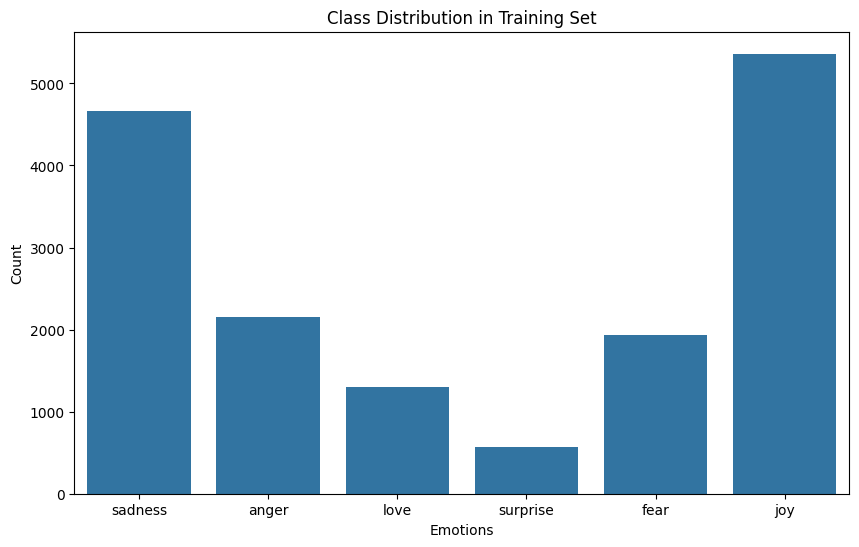

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df["emotions"])
plt.title('Class Distribution in Training Set')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()


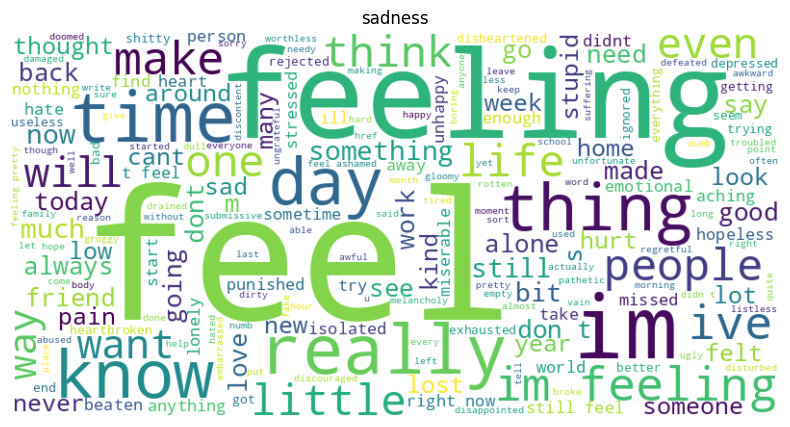

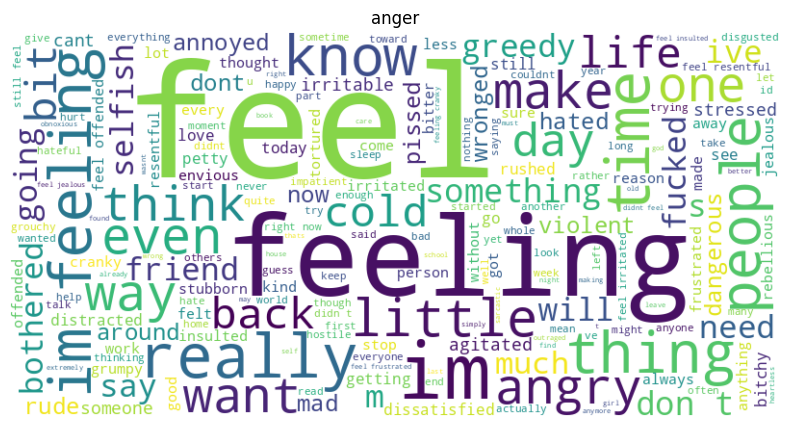

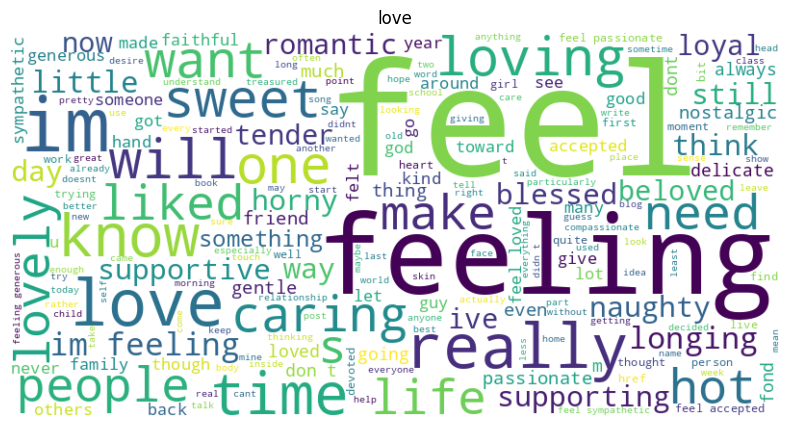

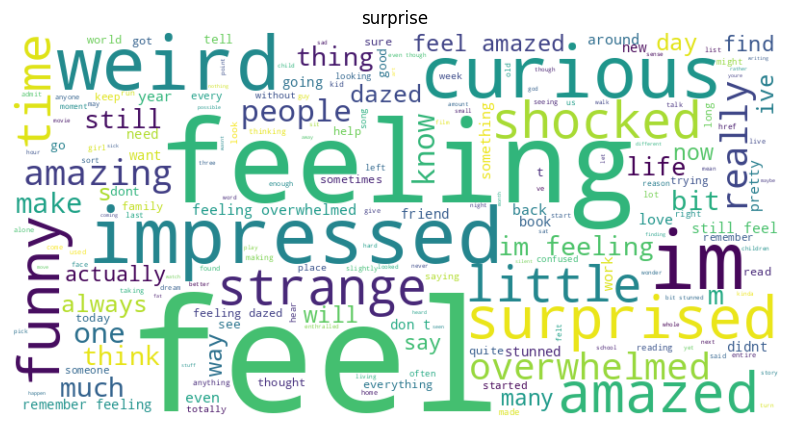

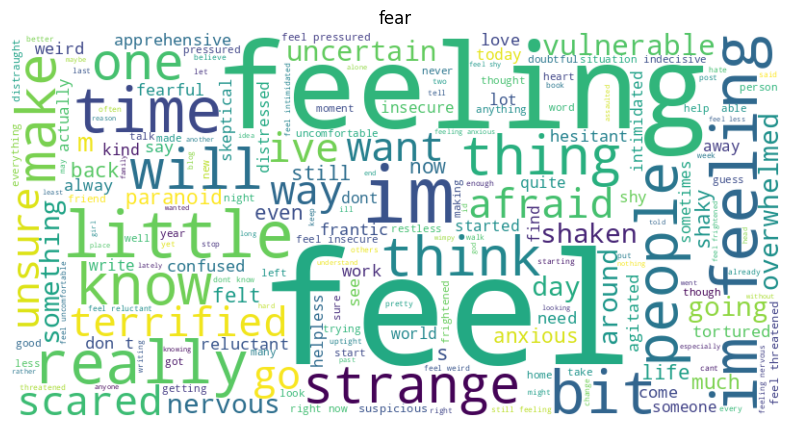

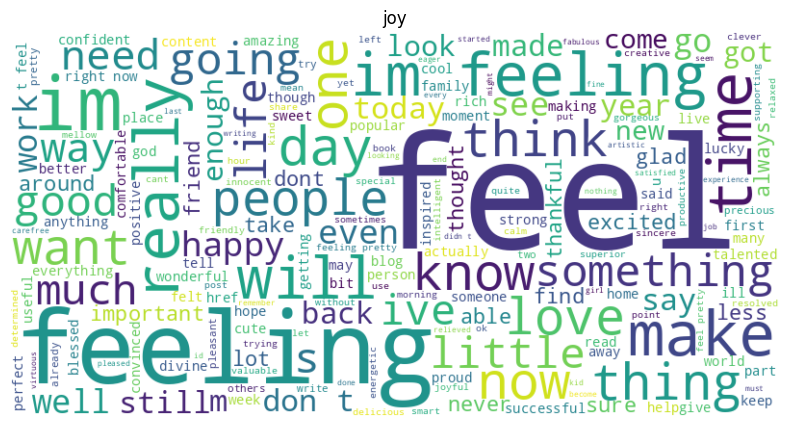

In [9]:
for emotion in train_df["emotions"].unique():
    subset = train_df[train_df["emotions"] == emotion]
    text = " ".join(subset["text"].values)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(emotion)
    plt.axis("off")
    plt.show()


# Tokenization

In [39]:
# Tokenize the dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(df):
    return tokenizer(df["text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_data(train_df)
test_encodings = tokenize_data(test_df)
val_encodings = tokenize_data(val_df)

In [40]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_df["label"].tolist())
test_dataset = CustomDataset(test_encodings, test_df["label"].tolist())
val_dataset = CustomDataset(val_encodings, val_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Additional Layers

In [41]:
import torch
import pickle
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

class CustomBERTModel(nn.Module):
    def __init__(self, bert_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        x = self.dropout(pooled_output)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        return logits

In [42]:
num_labels = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the custom BERT model
custom_model = CustomBERTModel('bert-base-uncased', num_labels)
# Move the model to the appropriate device
custom_model.to(device)

CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [43]:
optimizer = AdamW(custom_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training

In [44]:
for epoch in range(3):
    custom_model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        token_type_ids = batch['token_type_ids'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = custom_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Training Loss: {avg_train_loss:.2f}")

    custom_model.eval()
    total_val_loss = 0
    for batch in val_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            token_type_ids = batch['token_type_ids'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = custom_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch + 1} | Validation Loss: {avg_val_loss:.2f}")

Epoch 1 | Training Loss: 0.48
Epoch 1 | Validation Loss: 0.24
Epoch 2 | Training Loss: 0.18
Epoch 2 | Validation Loss: 0.14
Epoch 3 | Training Loss: 0.15
Epoch 3 | Validation Loss: 0.16


# Predictions & Evaluation

In [47]:
import torch
from torch.nn.functional import softmax

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the function to predict emotion
def predict_emotion(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # Move inputs to the appropriate device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Put the model in evaluation mode and get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    # Map the predicted label to the corresponding emotion
    label_to_emotion = {
        0: "sadness",
        1: "anger",
        2: "love",
        3: "surprise",
        4: "fear",
        5: "joy"
    }
    predicted_emotion = label_to_emotion[predicted_label]

    # Get probabilities for each emotion
    probabilities = softmax(logits, dim=1).cpu().numpy()[0]

    return predicted_emotion, probabilities

# Example usage
text = "I am feeling very happy today!"
predicted_emotion, probabilities = predict_emotion(text, custom_model, tokenizer)

print(f"Predicted Emotion: {predicted_emotion}")
print("Probabilities:", probabilities)


Predicted Emotion: joy
Probabilities: [1.2647486e-04 5.9805083e-05 1.2666592e-04 3.6803158e-05 2.2354585e-05
 9.9962783e-01]


In [46]:
# Evaluation on the test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
predictions, true_labels = [], []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        token_type_ids = batch['token_type_ids'].to('cuda')
        labels = batch['labels'].to('cuda')


        outputs = custom_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=mapping.keys()))

              precision    recall  f1-score   support

     sadness       0.95      0.98      0.97       581
       anger       1.00      0.87      0.93       275
        love       0.81      0.83      0.82       159
    surprise       0.70      0.83      0.76        66
        fear       0.93      0.85      0.89       224
         joy       0.94      0.96      0.95       695

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



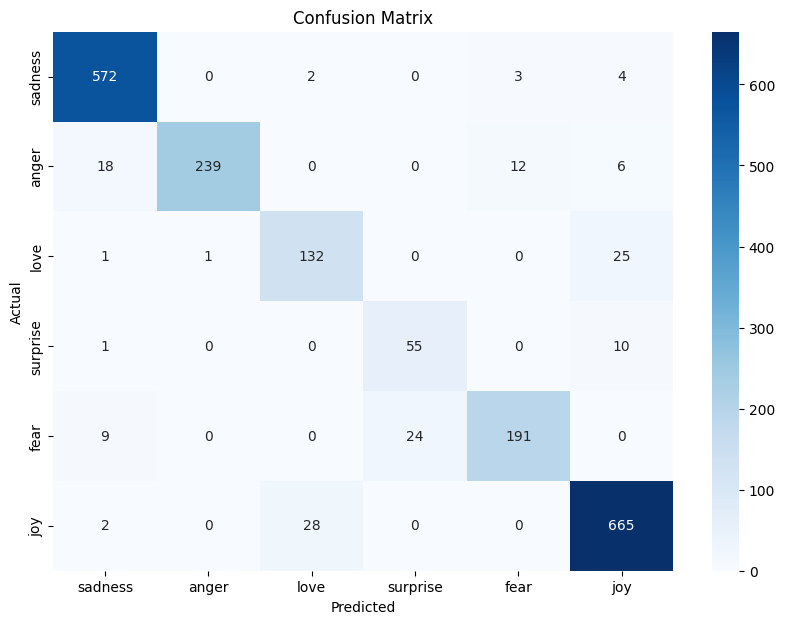

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping.keys()), yticklabels=list(mapping.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Saving The Model

In [49]:
# Save the model
torch.save(custom_model.state_dict(), "/content/drive/MyDrive/bert_emotion_model.pth")

# Save the tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/bert_tokenizer")


('/content/drive/MyDrive/bert_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/bert_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/bert_tokenizer/vocab.txt',
 '/content/drive/MyDrive/bert_tokenizer/added_tokens.json')

# Load The Model

In [54]:
import torch
import pickle
from transformers import BertTokenizer, BertForSequenceClassification

# Define the paths to load the files
model_path = "/content/drive/MyDrive/bert_emotion_model.pth"  # Change to .pth
tokenizer_path = "/content/drive/MyDrive/bert_tokenizer"  # Change to folder path

# Load the model state dictionary
model = CustomBERTModel('bert-base-uncased', num_labels)
model.load_state_dict(torch.load(model_path))  # Use torch.load
model.to('cuda')

# Load the tokenizer using the built-in method
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Function to predict emotion
def predict_emotion(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # Move inputs to GPU
    inputs = {key: val.to('cuda') for key, val in inputs.items()}

    # Put the model in evaluation mode and get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    # Map the predicted label to the corresponding emotion
    label_to_emotion = {0: "sadness", 1: "anger", 2: "love", 3: "surprise", 4: "fear", 5: "joy"}
    predicted_emotion = label_to_emotion[predicted_label]

    return predicted_emotion

# Example usage
text = "i also miss the old curious child within me i just feel that the curious child inside me is dying slowly upon the shock of knowing that the world is not as beautiful as we thought it was;"
predicted_emotion = predict_emotion(text, model, tokenizer)
print(f"The predicted emotion for the text is: {predicted_emotion}")


The predicted emotion for the text is: surprise
